# 03 - Dask: Distributed DataFrame

Bu notebook'ta Dask ile buyuk verileri nasil isledigimizi **NYC Taxi** verisi ile gorecegiz.

**Dask Ozellikleri:**
- Pandas API uyumlu (minimal kod degisikligi)
- Lazy evaluation (task graph)
- Out-of-core processing (RAM'den buyuk veriler)
- Distributed computing (birden fazla makine)
- TB+ veri isleyebilir

**Veri Seti:** NYC Yellow Taxi 2023 (12 ay, ~40M satir)

## 1. Kurulum

In [1]:
# Dask kurulumu
!pip install "dask[complete]" pyarrow -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 72.3 MB/s eta 0:00:00


In [2]:
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import pandas as pd
import time
import json
import os
import psutil
import gc
import urllib.request

print(f"Dask version: {dask.__version__}")
print(f"CPU count: {os.cpu_count()}")

# Progress bar aktif
ProgressBar().register()

Dask version: 2025.9.1
CPU count: 12


In [3]:
# Benchmark fonksiyonlari
results = {
    'framework': 'dask',
    'dataset': 'nyc_taxi_12_months',
    'operations': {}
}

def get_memory_mb():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def benchmark(func, name):
    gc.collect()
    mem_before = get_memory_mb()
    start = time.time()
    result = func()
    end = time.time()
    mem_after = get_memory_mb()
    
    duration = end - start
    mem_used = mem_after - mem_before
    
    results['operations'][name] = {
        'duration_sec': round(duration, 3),
        'memory_mb': round(mem_used, 2)
    }
    
    print(f"\n{'='*50}")
    print(f"Operation: {name}")
    print(f"Sure: {duration:.3f} saniye")
    print(f"Bellek: {mem_used:.2f} MB")
    print(f"{'='*50}")
    
    return result

In [4]:
# Veri indirme - 12 ay
DATA_DIR = 'data'
os.makedirs(DATA_DIR, exist_ok=True)

MONTHS = ['2023-01', '2023-02', '2023-03', '2023-04', '2023-05', '2023-06',
          '2023-07', '2023-08', '2023-09', '2023-10', '2023-11', '2023-12']
BASE_URL = "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{}.parquet"

taxi_files = []
total_size = 0

for month in MONTHS:
    filename = f"yellow_tripdata_{month}.parquet"
    filepath = os.path.join(DATA_DIR, filename)
    taxi_files.append(filepath)
    
    if not os.path.exists(filepath):
        url = BASE_URL.format(month)
        print(f"Indiriliyor: {filename}...")
        urllib.request.urlretrieve(url, filepath)
        print(f"Indirildi: {filename}")
    else:
        print(f"Mevcut: {filename}")
    
    total_size += os.path.getsize(filepath)

print(f"\nToplam dosya boyutu: {total_size / 1024**2:.1f} MB")
print(f"Dosya sayisi: {len(taxi_files)}")

Mevcut: yellow_tripdata_2023-01.parquet
Mevcut: yellow_tripdata_2023-02.parquet
Mevcut: yellow_tripdata_2023-03.parquet
Mevcut: yellow_tripdata_2023-04.parquet
Mevcut: yellow_tripdata_2023-05.parquet
Mevcut: yellow_tripdata_2023-06.parquet
Mevcut: yellow_tripdata_2023-07.parquet
Mevcut: yellow_tripdata_2023-08.parquet
Mevcut: yellow_tripdata_2023-09.parquet
Mevcut: yellow_tripdata_2023-10.parquet
Mevcut: yellow_tripdata_2023-11.parquet
Mevcut: yellow_tripdata_2023-12.parquet

Toplam dosya boyutu: 606.3 MB
Dosya sayisi: 12


## 2. Dask DataFrame Yukleme

**ONEMLI:** Dask varsayilan olarak LAZY!
- `read_parquet()` hemen veri yuklemez
- Sadece metadata okur
- Gercek islem `.compute()` ile baslar

In [5]:
# Dask ile veri yukle - LAZY!
def load_dask_lazy():
    return dd.read_parquet(taxi_files)

ddf = load_dask_lazy()
print(f"\nPartition sayisi: {ddf.npartitions}")
print(f"Sutunlar: {list(ddf.columns)}")
print("\nNOT: Veri henuz yuklenmedi! (Lazy evaluation)")
print(f"Bellek kullanimi: {get_memory_mb():.0f} MB")


Partition sayisi: 12
Sutunlar: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']

NOT: Veri henuz yuklenmedi! (Lazy evaluation)
Bellek kullanimi: 262 MB


In [6]:
# Ilk birkac satiri goster (.head() compute yapar)
ddf.head()

[########################################] | 100% Completed | 1.61 ss


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


## 3. Task Graph Gorsellestirme

Dask islemleri bir task graph olarak temsil eder.

Basit bir islem icin task graph:


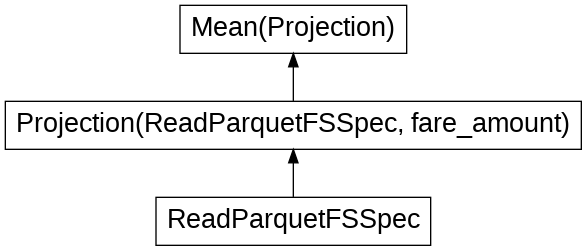

In [7]:
# Task graph goster
print("Basit bir islem icin task graph:")
simple_op = ddf['fare_amount'].mean()

# Graph'i gorsellestir (Colab'da calisir)
try:
    simple_op.visualize(filename='task_graph.png')
    from IPython.display import Image
    display(Image('task_graph.png'))
except:
    print("Graphviz yuklu degil, task graph gosterilemiyor")
    print(f"Task sayisi: {len(simple_op.__dask_graph__())}")

## 4. Temel Islemler

### 4.1 Veri Yukleme (compute)

In [8]:
# Satir sayisini hesapla (compute gerektirir)
def load_and_count():
    return len(ddf)  # Bu compute yapar

row_count = benchmark(load_and_count, 'load_data')
print(f"\nToplam satir: {row_count:,}")

[########################################] | 100% Completed | 101.30 ms

Operation: load_data
Sure: 0.114 saniye
Bellek: 0.73 MB

Toplam satir: 38,310,226


### 4.2 Filtreleme

In [9]:
def filter_trips():
    filtered = ddf[
        (ddf['trip_distance'] > 5) &
        (ddf['fare_amount'] > 20) &
        (ddf['fare_amount'] < 500)
    ]
    return len(filtered)  # compute tetikler

filtered_count = benchmark(filter_trips, 'filter_trips')
print(f"\nFiltrelenmis: {filtered_count:,}")

[########################################] | 100% Completed | 911.46 ms

Operation: filter_trips
Sure: 0.931 saniye
Bellek: 272.68 MB

Filtrelenmis: 6,542,088


### 4.3 GroupBy - Saatlik Analiz

In [10]:
def groupby_hour():
    # Dask'ta datetime islemleri
    ddf_with_hour = ddf.assign(pickup_hour=ddf['tpep_pickup_datetime'].dt.hour)
    
    result = ddf_with_hour.groupby('pickup_hour').agg({
        'fare_amount': 'mean',
        'trip_distance': 'mean',
        'tip_amount': 'mean',
        'VendorID': 'count'
    }).compute()
    
    result.columns = ['avg_fare', 'avg_distance', 'avg_tip', 'trip_count']
    return result.sort_index()

df_hourly = benchmark(groupby_hour, 'groupby_hour')
df_hourly

[########################################] | 100% Completed | 2.83 ss

Operation: groupby_hour
Sure: 2.861 saniye
Bellek: 995.33 MB


,avg_fare,avg_distance,avg_tip,trip_count
pickup_hour,,,,
0,19.857420,4.031465,3.496476,1088628
1,18.010486,3.631036,3.170270,731321
2,16.919905,4.401059,2.939176,483366
3,17.911575,4.760022,3.011689,319641
4,23.553610,10.257194,3.652719,217492
5,27.447236,11.625794,4.242081,226411
6,22.958906,8.691477,3.617328,532181
7,19.473654,5.978029,3.341630,1044241
8,18.611942,4.447673,3.294112,1446062


### 4.4 GroupBy - Aylik Analiz

In [11]:
def groupby_month():
    ddf_with_month = ddf.assign(pickup_month=ddf['tpep_pickup_datetime'].dt.month)
    
    result = ddf_with_month.groupby('pickup_month').agg({
        'fare_amount': ['mean', 'sum'],
        'trip_distance': 'mean',
        'tip_amount': 'sum',
        'VendorID': 'count'
    }).compute()
    
    result.columns = ['avg_fare', 'total_fare', 'avg_distance', 'total_tips', 'trip_count']
    return result.sort_index()

df_monthly = benchmark(groupby_month, 'groupby_month')
df_monthly

[########################################] | 100% Completed | 2.83 ss

Operation: groupby_month
Sure: 2.859 saniye
Bellek: 946.21 MB


,avg_fare,total_fare,avg_distance,total_tips,trip_count
pickup_month,,,,,
1,18.367123,56327538.73,3.847384,10328582.28,3066759
2,18.220242,53093841.17,3.867976,9863234.47,2914003
3,18.908529,64358203.73,3.903942,11896858.92,3403660
4,19.360496,63662112.02,4.096160,11548492.49,3288248
5,19.876823,69840476.35,4.345793,12683914.45,3513664
6,19.987926,66105246.64,4.368754,11889273.41,3307259
7,19.703376,57279546.53,4.489437,10020336.23,2907093
8,19.718396,55688712.88,4.782777,9632297.07,2824201
9,20.671103,58845277.48,4.274258,10320233.10,2846741


### 4.5 Odeme Tipi Analizi

In [12]:
def payment_analysis():
    payment_map = {
        1: 'Credit Card',
        2: 'Cash',
        3: 'No Charge',
        4: 'Dispute',
        5: 'Unknown',
        6: 'Voided'
    }
    
    ddf_with_payment = ddf.assign(
        payment_name=ddf['payment_type'].map(payment_map, meta=('payment_name', 'str'))
    )
    
    result = ddf_with_payment.groupby('payment_name').agg({
        'fare_amount': 'mean',
        'tip_amount': 'mean',
        'total_amount': 'sum',
        'VendorID': 'count'
    }).compute()
    
    result.columns = ['avg_fare', 'avg_tip', 'total_revenue', 'trip_count']
    return result.sort_values('trip_count', ascending=False)

df_payment = benchmark(payment_analysis, 'payment_analysis')
df_payment

[########################################] | 100% Completed | 5.02 ss

Operation: payment_analysis
Sure: 5.049 saniye
Bellek: 529.00 MB


,avg_fare,avg_tip,total_revenue,trip_count
payment_name,,,,
Credit Card,19.814779,4.396301,8.907791e+08,29856932
Cash,19.388154,0.001941,1.570502e+08,6405059
Dispute,1.724659,0.051580,1.130853e+06,498015
No Charge,8.127843,0.035321,2.540632e+06,240862
Unknown,0.000000,0.000000,0.000000e+00,2


### 4.6 Location Analizi

In [13]:
def location_analysis():
    result = ddf.groupby('PULocationID').agg({
        'VendorID': 'count',
        'fare_amount': 'mean',
        'trip_distance': 'mean',
        'tip_amount': 'mean'
    }).compute()
    
    result.columns = ['trip_count', 'avg_fare', 'avg_distance', 'avg_tip']
    return result.sort_values('trip_count', ascending=False)

df_locations = benchmark(location_analysis, 'location_analysis')
print("\nEn Populer 15 Pickup Lokasyonu:")
df_locations.head(15)

[########################################] | 100% Completed | 1.93 ss

Operation: location_analysis
Sure: 1.952 saniye
Bellek: 102.46 MB

En Populer 15 Pickup Lokasyonu:


,trip_count,avg_fare,avg_distance,avg_tip
PULocationID,,,,
132,1992304,61.080875,15.829447,8.688623
237,1791795,13.009022,1.926180,2.665287
161,1766041,16.473684,2.637109,3.230466
236,1596584,13.584188,2.137991,2.766769
162,1353753,15.879083,2.648804,3.152426
138,1305259,42.688226,9.857485,8.664628
186,1305113,16.984974,2.449244,3.162617
230,1270681,19.279069,3.472265,3.477988
142,1256024,14.334973,2.802366,2.894276


### 4.7 En Pahali Yolculuklar

In [14]:
def top_expensive_trips():
    return ddf.nlargest(1000, 'total_amount')[[
        'tpep_pickup_datetime', 'trip_distance',
        'fare_amount', 'tip_amount', 'total_amount',
        'PULocationID', 'DOLocationID'
    ]].compute()

df_expensive = benchmark(top_expensive_trips, 'top_expensive_trips')
print("\nEn Pahali 10 Yolculuk:")
df_expensive.head(10)

[########################################] | 100% Completed | 2.44 ss

Operation: top_expensive_trips
Sure: 2.472 saniye
Bellek: 591.64 MB

En Pahali 10 Yolculuk:


,tpep_pickup_datetime,trip_distance,fare_amount,tip_amount,total_amount,PULocationID,DOLocationID
1252949,2023-06-12 13:33:06,1.50,386983.63,0.0,386987.63,100,50
125016,2023-09-02 15:15:39,21.30,187502.96,0.0,187513.90,239,132
330801,2023-09-05 10:16:13,0.70,143163.45,0.0,143167.45,249,90
1024266,2023-09-11 14:54:55,0.00,19152.90,0.0,29156.90,43,264
2667313,2023-09-30 17:58:34,0.00,12015.47,0.0,12015.47,163,264
3477407,2023-10-23 20:43:13,0.00,6339.00,0.0,6339.00,48,125
1715470,2023-05-16 10:12:28,40.81,6300.90,0.0,6304.90,239,264
1289116,2023-12-12 07:51:03,0.00,95.16,4174.0,4269.16,264,264
568483,2023-04-06 14:08:51,12.58,2449.50,0.0,2451.00,216,265
2298626,2023-12-20 18:49:49,6.70,2320.11,0.0,2372.79,233,40


### 4.8 Rolling Statistics (Hareketli Ortalama)

In [15]:
def daily_rolling_stats():
    # Gunluk toplamlar
    ddf_with_date = ddf.assign(pickup_date=ddf['tpep_pickup_datetime'].dt.date)
    
    daily = ddf_with_date.groupby('pickup_date').agg({
        'fare_amount': 'sum',
        'trip_distance': 'sum',
        'VendorID': 'count'
    }).compute()
    
    daily.columns = ['daily_fare', 'daily_distance', 'trip_count']
    daily = daily.sort_index()
    
    # Rolling hesaplamalari pandas'ta
    daily['fare_7d_avg'] = daily['daily_fare'].rolling(7).mean()
    daily['trips_7d_avg'] = daily['trip_count'].rolling(7).mean()
    
    return daily

df_daily = benchmark(daily_rolling_stats, 'daily_rolling_stats')
df_daily.tail(10)

[########################################] | 100% Completed | 14.33 s

Operation: daily_rolling_stats
Sure: 14.359 saniye
Bellek: 930.16 MB


,daily_fare,daily_distance,trip_count,fare_7d_avg,trips_7d_avg
pickup_date,,,,,
2023-12-24,1165533.76,213135.12,65697,1.928531e+06,102830.857143
2023-12-25,936450.20,232377.30,45466,1.787275e+06,94814.142857
2023-12-26,1427927.72,287616.43,68261,1.663229e+06,87131.000000
2023-12-27,1709622.23,309827.57,81293,1.586211e+06,81787.000000
2023-12-28,1770609.03,314216.55,84419,1.521062e+06,77119.142857
2023-12-29,1770287.27,317479.94,86171,1.478444e+06,73517.000000
2023-12-30,1680648.99,320304.65,82501,1.494440e+06,73401.142857
2023-12-31,1472304.08,281323.76,76955,1.538264e+06,75009.428571
2024-01-01,17.20,2.41,2,1.404488e+06,68514.571429


## 5. Dask'in Gucu: Out-of-Core Processing

In [16]:
print("""
DASK OUT-OF-CORE PROCESSING
===========================

Dask veriyi partition'lara boler ve her birini ayri isler:

1. CHUNKING
   - Her parquet dosyasi bir partition
   - Her partition bagimsiz islenir
   - RAM'e sadece aktif partition yuklenir

2. LAZY EVALUATION
   - Islemler task graph'a eklenir
   - .compute() cagrilana kadar calismiyor
   - Optimizer gereksiz islemleri eler

3. SCHEDULER
   - synchronous: Tek thread (debug icin)
   - threaded: Multi-thread (varsayilan)
   - processes: Multi-process (CPU-bound)
   - distributed: Cluster (TB+ veri)
""")

print(f"\nMevcut partition sayisi: {ddf.npartitions}")
print(f"Satir/partition (tahmini): {row_count // ddf.npartitions:,}")


DASK OUT-OF-CORE PROCESSING

Dask veriyi partition'lara boler ve her birini ayri isler:

1. CHUNKING
   - Her parquet dosyasi bir partition
   - Her partition bagimsiz islenir
   - RAM'e sadece aktif partition yuklenir

2. LAZY EVALUATION
   - Islemler task graph'a eklenir
   - .compute() cagrilana kadar calismiyor
   - Optimizer gereksiz islemleri eler

3. SCHEDULER
   - synchronous: Tek thread (debug icin)
   - threaded: Multi-thread (varsayilan)
   - processes: Multi-process (CPU-bound)
   - distributed: Cluster (TB+ veri)


Mevcut partition sayisi: 12
Satir/partition (tahmini): 3,192,518


## 6. Farkli Scheduler'lar

In [17]:
# Farkli scheduler'lari karsilastir
test_op = ddf['fare_amount'].mean()

schedulers = ['synchronous', 'threads']

print("SCHEDULER KARSILASTIRMASI")
print("="*50)

for scheduler in schedulers:
    start = time.time()
    result = test_op.compute(scheduler=scheduler)
    duration = time.time() - start
    print(f"{scheduler:<15}: {duration:.3f}s (result: ${result:.2f})")

SCHEDULER KARSILASTIRMASI
[########################################] | 100% Completed | 1.21 sms
synchronous    : 1.220s (result: $19.52)
[########################################] | 100% Completed | 405.89 ms
threads        : 0.413s (result: $19.52)


## 7. Dask vs Pandas vs Polars Karsilastirma

In [18]:
# Onceki sonuclari yukle
all_results = {}
for fw in ['pandas', 'polars', 'dask']:
    try:
        with open(f'results/{fw}_benchmark.json', 'r') as f:
            all_results[fw] = json.load(f)
    except:
        pass

all_results['dask'] = results  # guncel sonuclar

In [19]:
if len(all_results) > 1:
    print("\n" + "="*80)
    print("FRAMEWORK KARSILASTIRMASI (12 Ay NYC Taxi)")
    print("="*80)
    
    operations = list(results['operations'].keys())
    
    print(f"{'Islem':<25}", end='')
    for fw in all_results:
        print(f"{fw:<12}", end='')
    print()
    print("-"*80)
    
    for op in operations:
        print(f"{op:<25}", end='')
        for fw in all_results:
            if op in all_results[fw]['operations']:
                t = all_results[fw]['operations'][op]['duration_sec']
                print(f"{t:<12.3f}", end='')
            else:
                print(f"{'N/A':<12}", end='')
        print()
    
    print("-"*80)
    
    # Toplamlar
    print(f"{'TOPLAM':<25}", end='')
    for fw in all_results:
        total = sum(all_results[fw]['operations'].get(op, {}).get('duration_sec', 0) for op in operations)
        print(f"{total:<12.1f}", end='')
    print()


FRAMEWORK KARSILASTIRMASI (12 Ay NYC Taxi)
Islem                    pandas      polars      dask        
--------------------------------------------------------------------------------
load_data                5.228       2.503       0.114       
filter_trips             1.232       0.194       0.931       
groupby_hour             2.443       0.278       2.861       
groupby_month            3.600       0.268       2.859       
payment_analysis         4.316       0.393       5.049       
location_analysis        1.295       0.895       1.952       
top_expensive_trips      9.214       1.830       2.472       
daily_rolling_stats      34.781      0.771       14.359      
--------------------------------------------------------------------------------
TOPLAM                   62.1        7.1         30.6        


## 8. Sonuclari Kaydet

In [20]:
results['total_memory_mb'] = round(get_memory_mb(), 2)
results['total_memory_gb'] = round(get_memory_mb() / 1024, 2)
results['row_count'] = row_count
results['partitions'] = ddf.npartitions

os.makedirs('results', exist_ok=True)
with open('results/dask_benchmark.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Sonuclar kaydedildi: results/dask_benchmark.json")
print("\n" + json.dumps(results, indent=2))

Sonuclar kaydedildi: results/dask_benchmark.json

{
  "framework": "dask",
  "dataset": "nyc_taxi_12_months",
  "operations": {
    "load_data": {
      "duration_sec": 0.114,
      "memory_mb": 0.73
    },
    "filter_trips": {
      "duration_sec": 0.931,
      "memory_mb": 272.68
    },
    "groupby_hour": {
      "duration_sec": 2.861,
      "memory_mb": 995.33
    },
    "groupby_month": {
      "duration_sec": 2.859,
      "memory_mb": 946.21
    },
    "payment_analysis": {
      "duration_sec": 5.049,
      "memory_mb": 529.0
    },
    "location_analysis": {
      "duration_sec": 1.952,
      "memory_mb": 102.46
    },
    "top_expensive_trips": {
      "duration_sec": 2.472,
      "memory_mb": 591.64
    },
    "daily_rolling_stats": {
      "duration_sec": 14.359,
      "memory_mb": 930.16
    }
  },
  "total_memory_mb": 3581.29,
  "total_memory_gb": 3.5,
  "row_count": 38310226,
  "partitions": 12
}


## 9. Dask Ozet

In [21]:
print("""
DASK AVANTAJLARI
================

1. PANDAS API UYUMLU
   - Minimal kod degisikligi
   - Mevcut Pandas bilgisi yeterli
   - .compute() ekle, gerisi ayni

2. OUT-OF-CORE
   - RAM'den buyuk veriler
   - Otomatik chunking
   - Disk-based processing

3. DISTRIBUTED
   - Cluster computing
   - TB+ veri isleyebilir
   - dask.distributed scheduler

4. LAZY EVALUATION
   - Query optimization
   - Task graph gorsellestirme
   - Gereksiz islemleri eler

NE ZAMAN DASK?
==============
- Veri RAM'e sigmiyor
- TB+ ETL pipelines
- Pandas kodunu scale etmek istiyorsunuz
- Cluster kullanmak istiyorsunuz

NE ZAMAN POLARS?
================
- Veri RAM'e sigiyor
- Tek makinede maksimum hiz istiyorsunuz

NE ZAMAN RAY?
=============
- ML pipeline / training
- Hyperparameter tuning
- Distributed model training
""")


DASK AVANTAJLARI

1. PANDAS API UYUMLU
   - Minimal kod degisikligi
   - Mevcut Pandas bilgisi yeterli
   - .compute() ekle, gerisi ayni

2. OUT-OF-CORE
   - RAM'den buyuk veriler
   - Otomatik chunking
   - Disk-based processing

3. DISTRIBUTED
   - Cluster computing
   - TB+ veri isleyebilir
   - dask.distributed scheduler

4. LAZY EVALUATION
   - Query optimization
   - Task graph gorsellestirme
   - Gereksiz islemleri eler

NE ZAMAN DASK?
- Veri RAM'e sigmiyor
- TB+ ETL pipelines
- Pandas kodunu scale etmek istiyorsunuz
- Cluster kullanmak istiyorsunuz

NE ZAMAN POLARS?
- Veri RAM'e sigiyor
- Tek makinede maksimum hiz istiyorsunuz

NE ZAMAN RAY?
- ML pipeline / training
- Hyperparameter tuning
- Distributed model training



---

## Sonraki Adim

ML workloads icin: **Ray**

-> `04_ray_ml_pipeline.ipynb`